In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt
import modelutils_v2 as modelutils
import copy

In [2]:
npeople = 50
tsteps = 14
ax=None
ntrials = 5
action = None
nlocations = 10
ntests=5


#ff = 40*[1000]+10*[1]
#ff=None
lambda_ = 40*[3e-3]+ 10*[1e-2]
homelocs = np.zeros([nlocations,npeople])
for person_idx in range(npeople):
    homelocs[np.random.choice(np.arange(nlocations)),person_idx]=1.

init_state = modelutils.state(homelocs) 

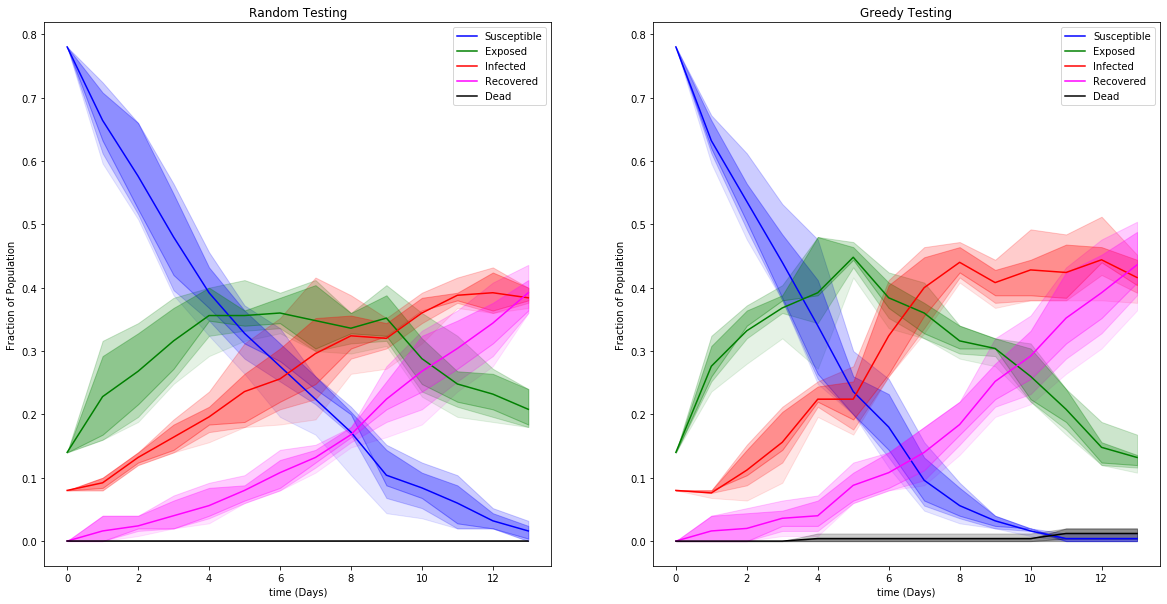

In [3]:
init_state = modelutils.state(homelocs,lambda_=lambda_)

action_random = init_state.random_action(ntests)
action_greedy = init_state.greedy_action(ntests)

random_series = []
greedy_series = []

greedy_history = []
random_history = []  #stores history of testing actions; to check if any individuals are "preferred"

for _ in range(ntrials):
    #print('Trial: ',_,end='\r')
    states_random = [copy.deepcopy(init_state)]
    states_greedy = [copy.deepcopy(init_state)]
    
    for time_idx in range(tsteps-1):
        print('Trial: ',_,'/ Time: ',time_idx,end='\r')
        states_random.append(states_random[-1].update_state(action_random))
        states_greedy.append(states_greedy[-1].update_state(action_greedy))
        
        action_random = states_random[-1].random_action(ntests=ntests)
        action_greedy = states_greedy[-1].greedy_action(ntests=ntests)
        
        greedy_history += list(np.where(action_greedy==1)[0])
        random_history += list(np.where(action_random==1)[0])
        
    random_series.append(modelutils.gen_plotmat(states_random))
    greedy_series.append(modelutils.gen_plotmat(states_greedy))
    
random_percentiles = modelutils.gen_percentiles(random_series)
greedy_percentiles = modelutils.gen_percentiles(greedy_series)

fig,ax = plt.subplots(figsize=(20,10),ncols=2)
ax[0] = modelutils.plot_percentiles(random_percentiles,random_series,ax[0])
ax[0].set_title('Random Testing')
ax[1] = modelutils.plot_percentiles(greedy_percentiles,greedy_series,ax[1])
ax[1].set_title('Greedy Testing')
plt.savefig('greedy_policy.png')

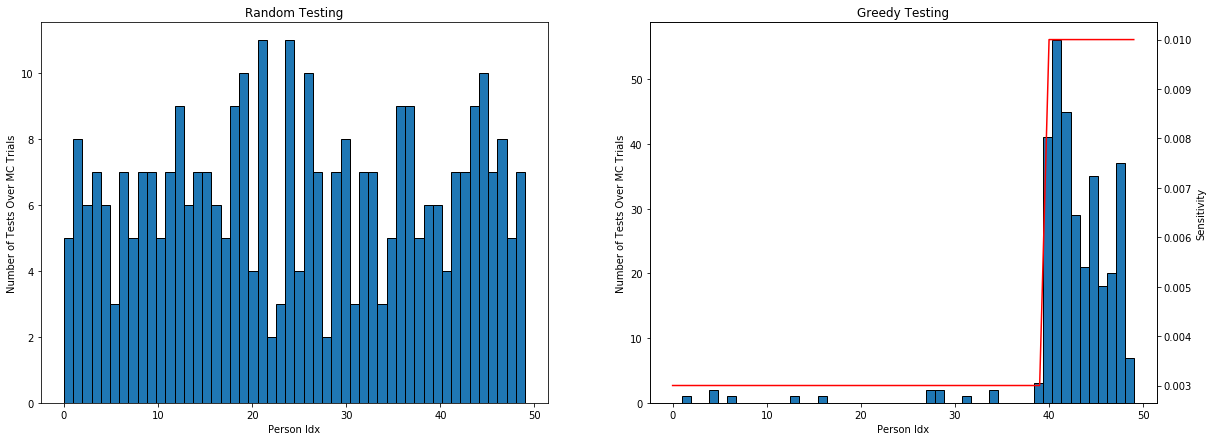

In [4]:
fig,ax = plt.subplots(ncols=2,figsize=(20,7))

_=ax[0].hist(random_history,edgecolor='black',bins=npeople)
_=ax[1].hist(greedy_history,edgecolor='black',bins=npeople)

ax2 = ax[1].twinx()
ax2.plot(np.arange(npeople),lambda_,'-r')

ax2.set_ylabel('Sensitivity')
ax[0].set_xlabel('Person Idx')
ax[1].set_xlabel('Person Idx')
ax[0].set_ylabel('Number of Tests Over MC Trials')
ax[1].set_ylabel('Number of Tests Over MC Trials')
ax[0].set_title('Random Testing')
ax[1].set_title('Greedy Testing')
plt.savefig('action_history.png')